In [1]:
# импорт всех библитотек
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
from scipy import stats as st
import numpy as np
import random
# using datetime module
import datetime;
# using datetime module
import datetime;
ct = datetime.datetime.now().timestamp()
import warnings
warnings.filterwarnings("ignore")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [2]:
tt = pd.read_csv('histor.csv', sep = ';')
tt['ddate'] = pd.to_datetime(tt['ddate'], format='%Y.%m.%d %H:%M:%S')
tt['created_at'] = pd.to_datetime(tt['created_at'], format='%Y.%m.%d %H:%M:%S')
len(tt.name.unique())

1091

In [3]:
# создадим функцию для присваивания кол-ва соответствий
def query_match(query, table=tt, variant = 'exact'):
    if variant == 'exact':
        query = query.split()
        ps = PorterStemmer()
        q = []
        for w in query:
            q.append(ps.stem(w))
        print(q)
        query = q
        counts = len(query)
        dd = table
        for i in query:
            if counts > query.index(i) - 1:
                yea = query.index(i)
                dd[f'col_{yea}'] = dd['cloud'].str.count(i)
                dd = dd.query(f'col_{yea} > 0').reset_index(drop=True)
                dd[f'col_{yea}'] = dd[f'col_{yea}'].fillna(0)
                dd[f'col_{yea}'] = dd[f'col_{yea}'].astype(int)
        dd['match_counts'] = ''
        for i in query:
            if counts > query.index(i) - 1:
                yea = query.index(i)
                dd['match_counts'] = dd['match_counts'] + '|' + dd[f'col_{yea}'].astype(str)
        dd['match_counts'] = dd['match_counts'].str.lstrip('')
        dd = dd[['name', 'match_counts']]
        for i, row in dd.iterrows():
            dd.loc[i, 'ematchs'] = min(row['match_counts'])
        try:
            dd = dd[['name', 'ematchs']].reset_index()
            result = dd.pivot_table(index = 'name', values = 'ematchs', aggfunc = 'min').reset_index()
            result['ematchs'] = result['ematchs'].astype(int)
            return result.sort_values(by=['ematchs', 'name'], ascending=False)
        except:
            print('Функция exact таких треков не нашла')
            return False
    elif variant == 'tag':
        query = query.split()
        ps = PorterStemmer()
        q = []
        for w in query:
            q.append(ps.stem(w))
        print(q)
        query = q
        counts = len(query)
        dd = table
        for i in query:
            if counts > query.index(i) - 1:
                yea = query.index(i)
                dd[f'col_{yea}'] = dd['cloud'].str.count(i)
        dd['tags'] = 0
        for i in query:
            if counts > query.index(i) - 1:
                yea = query.index(i)
                dd['tags'] = dd['tags'] + dd[f'col_{yea}']
        try:
            dd = dd[['name', 'tags']].reset_index()
            dd.tags.fillna(0)
            result = dd.pivot_table(index = 'name', values = 'tags', aggfunc = 'max').reset_index()
            result['tags'] = result['tags'].astype(int)
            result.loc[result['tags'] >4, 'tags'] = 4 # фильтр что тегов не больше 4-х
            return result.sort_values(by=['tags', 'name'], ascending=False)
        except:
            print('Функция tags таких треков не нашла')
            return False

Нам понадобиться также таблица сгрупппированная по трекам

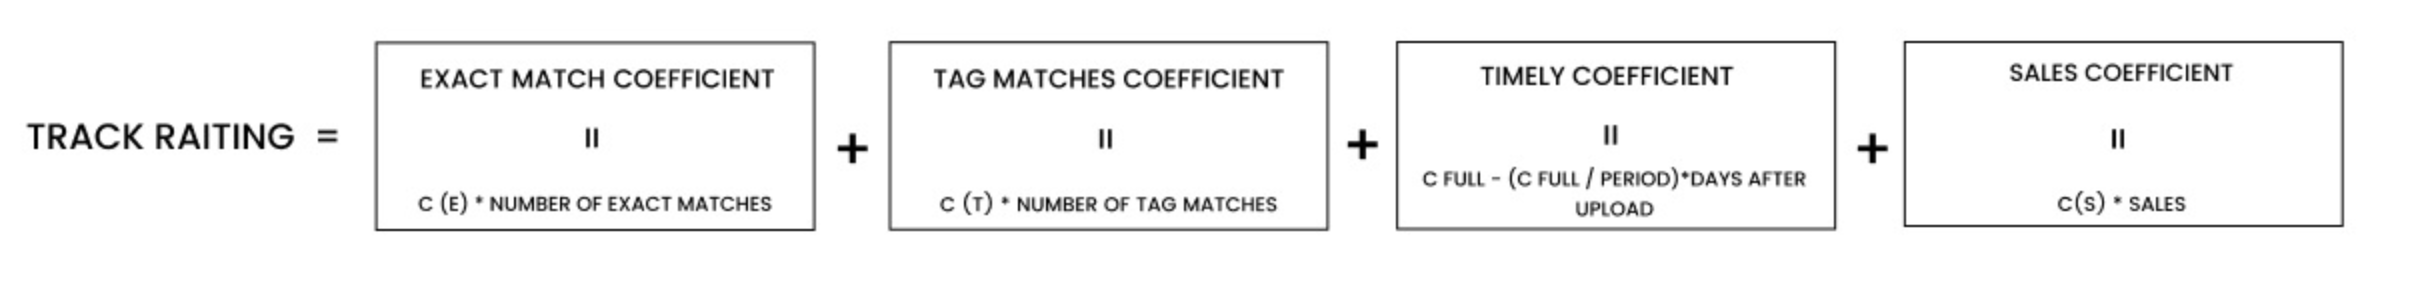

In [4]:
def search(query, c_exact, c_tag, c_full, period, timely_boost, c_s, c_t, N):
    words = query.split() # делим запрос на слова
    words = len(words) # узнаем длину запроса
    tt = pd.read_csv('histor.csv', sep=';') # подгружаем базу (предварительно еще с SQL поработал)
    # приводим даты к datetime
    tt['ddate'] = pd.to_datetime(tt['ddate'], format='%Y.%m.%d %H:%M:%S')
    tt['created_at'] = pd.to_datetime(tt['created_at'], format='%Y.%m.%d %H:%M:%S')
    # зададим и сгруппируем таблицу относительно N последних дней и создадим таблицу за этот период
    time = np.datetime64('today', 'D') - np.timedelta64(N, 'D')
    tt_period = tt.query(f'ddate > "{time}"') # оставим только актуальные данные по дате
    tt_period.loc[tt_period['license'].str.contains('Creator|Business', regex=True), 'subs_downloads'] = 1
    tt_period.loc[tt_period['license'].str.contains('Simple|Standard|Extended|Unlimited', regex=True), 'purchases'] = 1
    tt_period.reset_index(inplace=True, drop=True)
    tt_period = tt_period.fillna(0)
    tt_period = tt_period.groupby('name')['subs_downloads', 'purchases'].sum().reset_index()
    # данные для остальных метрик
    tt['sales_count'] = tt['sales_count'].fillna(0) # заменим наны на 0
    # сделаем сводную таблицу не по периоду а за все время и посчитаем кол-во дней у каждого трека
    tt_full = tt.pivot_table(index = ('name', 'created_at', 'sales_count'),\
                             values = 'license', aggfunc = 'count').reset_index()
    tt_full['days'] = (np.datetime64('today', 'D') + 1) - tt_full['created_at']
    tt_full['days'] = tt_full['days'].dt.days # добавим столбец сколько дней трек на сайте
    tt_full.loc[(tt_full['days'] >= period), 'days'] = period # больше заданного значения period дни равны period
    tt_full = tt_full[['name', 'sales_count', 'days']]
    tt_full.columns = ('name', 'sales', 'days')
    tt_result = tt_full.merge(tt_period, on='name', how='outer') # присоединим таблицу с кол-вом скачиваний за N дней
    # в итоге получили красивую таблицу за все время но с посчитанными скачиваниями за период (для трендового коэффициента)
    # если в запросе более 1 слова
    try:
        if words > 1:
            try:
                exact_table = query_match(query, table=tt, variant = 'exact')
                tt_result = tt_result.merge(exact_table, on='name', how='outer')
                tt_result['ematchs'] = tt_result['ematchs'].fillna(0)
                tag_table = query_match(query, table=tt, variant = 'tag')
                tt_result = tt_result.merge(tag_table, on='name', how='outer')
                tt_result['tags'] = tt_result['tags'].fillna(0)
                tt_result['exact match'] = tt_result['ematchs'] * c_exact                             # EXACT MATCH COEFF
                tt_result['tag match'] = tt_result['tags'] * c_tag                                    # TAG MATCH COEFF
                tt_result['timely'] = timely_boost * (c_full - (c_full / period * tt_result['days'])) # TIMELY COEFF
                tt_result['sales_coeff'] = c_s * tt_result['purchases']                               # SALES COEFF
                tt_result['trending_coeff'] = c_t * tt_result['subs_downloads']                       # TRENDING COEFF

                # ! - MAIN FORMULA FOR SENTENSES - !

                tt_result['track_rating'] = tt_result['exact match'] + tt_result['tag match'] + tt_result['timely'] +\
                                                                tt_result['sales_coeff'] + tt_result['trending_coeff']
                # ! - MAIN FORMULA FOR SENTENSES - !

                tt_result['em_rate'] = tt_result['exact match'] / tt_result['track_rating'] * 100
                tt_result['tm_rate'] = tt_result['tag match'] / tt_result['track_rating'] * 100
                tt_result['tly_rate'] = tt_result['timely'] / tt_result['track_rating'] * 100
                tt_result['sc_rate'] = tt_result['sales_coeff'] / tt_result['track_rating'] * 100
                tt_result['tr_rate'] = tt_result['trending_coeff'] / tt_result['track_rating'] * 100
                display(tt_result[['em_rate', 'tm_rate','tly_rate','sc_rate','tr_rate']].mean())
                tt_result = tt_result.sort_values(by='track_rating', ascending=False)
                return tt_result.query('track_rating > 0').reset_index()
                # если в запросе 1 слово
            except:
                print('Нет точных соответсвий')
                tag_table = query_match(query, table=tt, variant = 'tag')
                tt_result = tt_result.merge(tag_table, on='name', how='outer')
                tt_result= tt_result.fillna(0)

                tt_result['tag match'] = tt_result['tags'] * c_tag
                tt_result['timely'] = timely_boost * (c_full - (c_full / period) * tt_result['days'])
                tt_result['sales_coeff'] = c_s * tt_result['purchases']                              # SALES COEFF
                tt_result['trending_coeff'] = c_t * tt_result['subs_downloads']

                # ! - MAIN FORMULA FOR 1 WORD - !

                tt_result['track_rating'] = tt_result['tag match'] + tt_result['timely'] + tt_result['sales_coeff']+ \
                                                                                        tt_result['trending_coeff']
                # ! - MAIN FORMULA FOR 1 WORD - !

                tt_result['tm_rate'] = tt_result['tag match'] / tt_result['track_rating'] * 100
                tt_result['tly_rate'] = tt_result['timely'] / tt_result['track_rating'] * 100
                tt_result['sc_rate'] = tt_result['sales_coeff'] / tt_result['track_rating'] * 100
                tt_result['tr_rate'] = tt_result['trending_coeff'] / tt_result['track_rating'] * 100
                tt_result = tt_result.drop_duplicates('name')
                tt_result = tt_result.sort_values(by='track_rating', ascending=False).reset_index()
                display(tt_result[['tm_rate','tly_rate','sc_rate','tr_rate']].mean())
                return tt_result.query('track_rating > 0').reset_index()
        else:
            tag_table = query_match(query, table=tt, variant = 'tag')
            tt_result = tt_result.merge(tag_table)
            tt_result = tt_result.fillna(0)
            tt_result['tag match'] = tt_result['tags'] * c_tag
            tt_result['timely'] = timely_boost * (c_full - (c_full / period) * tt_result['days'])
            tt_result['sales_coeff'] = c_s * tt_result['purchases']
            tt_result['trending_coeff'] = c_t * tt_result['subs_downloads']
            # ! - MAIN FORMULA FOR 1 WORD - !

            tt_result['track_rating'] = tt_result['tag match'] + tt_result['timely'] + tt_result['sales_coeff']+ \
                                                                                    tt_result['trending_coeff']
            # ! - MAIN FORMULA FOR 1 WORD - !
            tt_result = tt_result.query('tags > 0')
            tt_result['tm_rate'] = tt_result['tag match'] / tt_result['track_rating'] * 100
            tt_result['tly_rate'] = tt_result['timely'] / tt_result['track_rating'] * 100
            tt_result['sc_rate'] = tt_result['sales_coeff'] / tt_result['track_rating'] * 100
            tt_result['tr_rate'] = tt_result['trending_coeff'] / tt_result['track_rating'] * 100
            tt_result = tt_result.drop_duplicates('name')
            tt_result = tt_result.sort_values(by='track_rating', ascending=False).reset_index()
            display(tt_result[['tm_rate','tly_rate','sc_rate','tr_rate']].mean())
            tt_result = tt_result.query('track_rating > 0')
            tt_result = tt_result.query('tags > 0').reset_index(drop=True)
            return tt_result
    except:
        print('Проверьте поисковый запрос')

In [17]:
search(
    query = 'corporate',
    c_exact = 100,
    c_tag = 2,
    c_full = 5,
    period = 90,
    timely_boost = 3.5,
    c_s = 2,
    c_t = 0.2,
    N = 90
)

['corpor']


tm_rate     63.039480
tly_rate     9.257969
sc_rate      7.968600
tr_rate     19.733951
dtype: float64

,index,name,sales,days,subs_downloads,purchases,tags,tag match,timely,sales_coeff,trending_coeff,track_rating,tm_rate,tly_rate,sc_rate,tr_rate
0,883,Sunsets,168.0,90,42.0,12.0,3,6,0.000000,24.0,8.4,38.400000,15.625000,0.000000,62.500000,21.875000
1,806,Sleep Sweetly,0.0,3,10.0,1.0,4,8,16.916667,2.0,2.0,28.916667,27.665706,58.501441,6.916427,6.916427
2,692,Pacific Ocean,147.0,90,31.0,7.0,2,4,0.000000,14.0,6.2,24.200000,16.528926,0.000000,57.851240,25.619835
3,495,Journey to the Dream,96.0,90,35.0,5.0,3,6,0.000000,10.0,7.0,23.000000,26.086957,0.000000,43.478261,30.434783
4,620,Moving Forward,0.0,3,9.0,1.0,1,2,16.916667,2.0,1.8,22.716667,8.804109,74.468085,8.804109,7.923698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,978,Titans,0.0,90,1.0,0.0,1,2,0.000000,0.0,0.2,2.200000,90.909091,0.000000,0.000000,9.090909
265,47,Autumn Leaves,0.0,90,1.0,0.0,1,2,0.000000,0.0,0.2,2.200000,90.909091,0.000000,0.000000,9.090909
266,546,Living In A Moment,0.0,90,1.0,0.0,1,2,0.000000,0.0,0.2,2.200000,90.909091,0.000000,0.000000,9.090909
267,166,Classic,0.0,90,0.0,0.0,1,2,0.000000,0.0,0.0,2.000000,100.000000,0.000000,0.000000,0.000000


Нужно придумать формулу, при которой будет присваиваться рейтинг всем трекам относительно метрик:
- Exact_match = C(E) * кол-во точных соответствий
- Tag_Matches = C(T) * кол-во совпадений тегов
- Timely Coefficient - состоит из формулы выше, (CFull/Period)*Days after upload
- Timely Boost - буст, для увеличения влияния коэффициента времени.
- Sales coefficient (продажи за все время) C(S) * Sales
- Trending Coefficient (скачивания за определенный период) C(T)*(Sub_Downloads + Sales) за последние N дней